In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def weights(shape, name):
    initial = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial, name)

def bias(shape, name):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial, name)

## 建立模型

### Encoder


In [5]:

tf.reset_default_graph()
sess = tf.InteractiveSession()

n_z = 2

X = tf.placeholder(tf.float32, shape = [None, 784])
batch_size = 50

def build_vae():
    W = []
    W_e_1 = weights([784, 500], "w_encoder_1")
    W.append(W_e_1)
    b_e_1 = bias([500], "b_encoder_1")
    h_e_1 = tf.nn.relu(tf.add(tf.matmul(X, W_e_1),b_e_1))
    
    W_e_2 = weights([500, 200], "w_encoder_2")
    W.append(W_e_2)
    b_e_2 = bias([200], "b_encoder_2")
    h_e_2 = tf.nn.relu(tf.add(tf.matmul(h_e_1, W_e_2),b_e_2))
    
    W_latent = weights([200, n_z], "w_latent")
    W.append(W_latent)
    b_latent = bias([n_z], "b_latent")
    z_mean = tf.add(tf.matmul(h_e_2, W_latent), b_latent)
    z_log_sigma = tf.add(tf.matmul(h_e_2, W_latent), b_latent)
    
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype = tf.float32)
    Z = tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_log_sigma)), eps))
    
    W_d_1 = weights([n_z, 200], "w_decoder_1")
    W.append(W_d_1)
    b_d_1 = bias([200], "b_decoder_1")
    h_d_1 = tf.nn.relu(tf.add(tf.matmul(Z, W_d_1), b_d_1))
    
    W_d_2 = weights([200, 500], "w_decoder_2")
    W.append(W_d_2)
    b_d_2 = bias([500], "b_decoder_2")
    h_d_2 = tf.nn.relu(tf.add(tf.matmul(h_d_1, W_d_2), b_d_2))
    
    W_d_3 = weights([500, 784], "w_decoder_3")
    W.append(W_d_3)
    b_d_3 = bias([784], "b_decoder_3")
    h_d_3 = tf.nn.sigmoid(tf.add(tf.matmul(h_d_2, W_d_3), b_d_3))
    
    X_reconstruct = h_d_3
    
    reconstruct_loss = -tf.reduce_sum(X * tf.log(1e-10 + X_reconstruct) + (1-X) * tf.log(1e-10 + 1 - X_reconstruct), 1)
    latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), 1)
    l2_loss = reduce(lambda x, y: x + y, map(lambda x: tf.nn.l2_loss(x), W))
    cost = tf.reduce_mean(reconstruct_loss + latent_loss)
    
    return Z, X_reconstruct, cost

In [6]:
Z, X_reconstruct, loss = build_vae()
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

### loss

In [7]:
init_op = tf.global_variables_initializer()
sess.run(init_op)
for i in range(20000):
    batch = mnist.train.next_batch(batch_size)
    if i%100 == 0:
        print("step %d, loss %g"%(i, loss.eval(feed_dict={X:batch[0]})))
    optimizer.run(feed_dict={X: batch[0]})

step 0, loss 620.589
step 100, loss 205.778
step 200, loss 184.09
step 300, loss 204.135
step 400, loss 180.577
step 500, loss 184.045
step 600, loss 177.779
step 700, loss 183.349
step 800, loss 178.328
step 900, loss 170.751
step 1000, loss 191.494
step 1100, loss 173.339
step 1200, loss 189.196
step 1300, loss 159.246
step 1400, loss 172.243
step 1500, loss 185.473
step 1600, loss 173.581
step 1700, loss 184.228
step 1800, loss 172.375
step 1900, loss 168.239
step 2000, loss 169.872
step 2100, loss 168.88
step 2200, loss 183.953
step 2300, loss 169.639
step 2400, loss 176.485
step 2500, loss 176.354
step 2600, loss 170.317
step 2700, loss 168.843
step 2800, loss 175.967
step 2900, loss 173.335
step 3000, loss 158.551
step 3100, loss 170.257
step 3200, loss 170.353
step 3300, loss 183.738
step 3400, loss 173.776
step 3500, loss 169.875
step 3600, loss 179.557
step 3700, loss 172.613
step 3800, loss 171.163
step 3900, loss 185.909
step 4000, loss 165.158
step 4100, loss 167.06
step 42

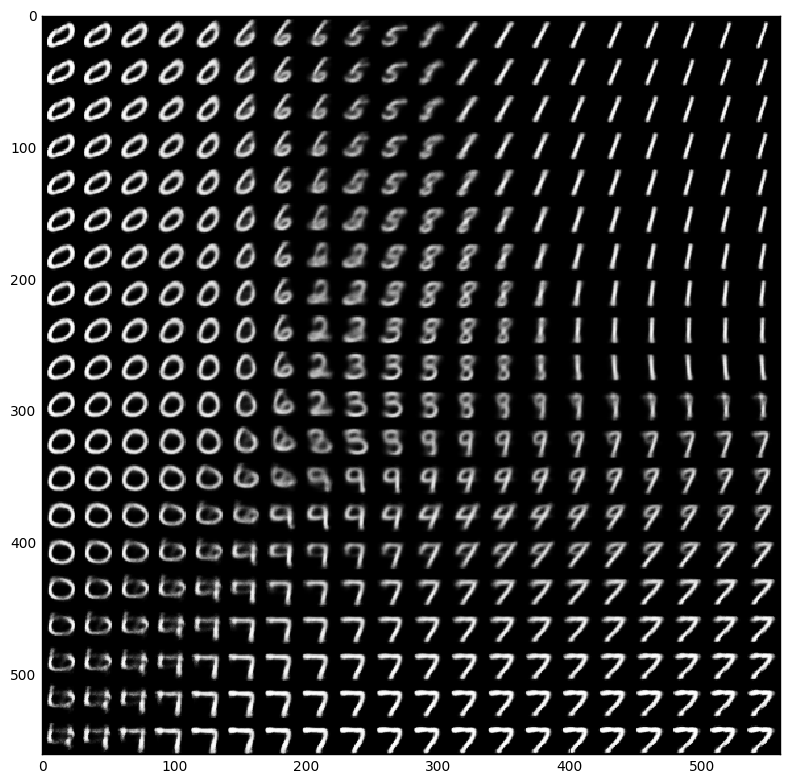

In [8]:
d = np.zeros([batch_size,2],dtype='float32')
nx = ny = 20
x_values = np.linspace(-8, 2, nx)
y_values = np.linspace(-8, 2, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        d[0] = z_mu
        x_mean = sess.run(X_reconstruct, feed_dict={Z: d})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()